## 1、download python retentioneering library

In [ ]:
!pip install retentioneering

## 2、import other library

In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
from retentioneering.eventstream import Eventstream
import datetime as dt
import retentioneering as ret
from retentioneering.tooling.clusters import Clusters
import matplotlib.pyplot as plt

## 3、data path

In [3]:
INPUT_PATH = Path("ali-cloud-dataset.csv")  
SESSION_GAP_HOURS = 2                      


dtype_map = {
    "user_id": "string",
    "item_id": "string",
    "behavior_type": "Int64",     # 1/2/3/4
    "item_category": "string",
    "date": "string",
    "hour": "string",
    "user_geohash": "string",
}


## 4、import data

In [4]:
df = pd.read_csv(
    INPUT_PATH,
    dtype=dtype_map,
)

## 五、data cleaning

In [5]:
# drop duplicate row
df = df.drop_duplicates()

# drop unnessisary row
keep_cols = ["user_id", "item_id", "behavior_type", "item_category", "date", "hour", "user_geohash"]
df = df[[c for c in keep_cols if c in df.columns]].copy()

# normalize
def _normalize_hour(h):
    if pd.isna(h):
        return np.nan
    h_str = str(h).strip()
    # 提取数字部分
    h_str = "".join(ch for ch in h_str if ch.isdigit())
    if h_str == "":
        return np.nan
    try:
        h_int = int(h_str)
    except ValueError:
        return np.nan
    if not (0 <= h_int <= 23):
        return np.nan
    return f"{h_int:02d}"

df["hour"] = df["hour"].map(_normalize_hour)

# drop the row with missing value
required_cols = ["user_id", "behavior_type", "date", "hour"]
df = df.dropna(subset=[c for c in required_cols if c in df.columns])

# extract timestamp（到小时粒度）
# 假设 date 形如 "2023-12-12"；若为 "2023/12/12" 也可解析
df["timestamp"] = pd.to_datetime(df["date"].str.strip() + " " + df["hour"].str.strip() + ":00:00", errors="coerce")
df = df.dropna(subset=["timestamp"])

# ============== map the even name（Retentioneering 需要 event 列） ==============
# 1：浏览(view)，2：收藏(favorite)，3：加购(cart)，4：购买(purchase)
event_map = {
    1: "view",
    2: "favorite",
    3: "cart",
    4: "purchase",
}
# behavior_type
df["behavior_type"] = pd.to_numeric(df["behavior_type"], errors="coerce").astype("Int64")
df["event"] = df["behavior_type"].map(event_map).astype("string")

# drop the event that cannot identify
df = df[~df["event"].isna()].copy()

# ============== rank by time（用户内按时间） ==============
df = df.sort_values(by=["user_id", "timestamp", "item_id"], kind="mergesort").reset_index(drop=True)

# ============== cut the session（弱会话：相邻事件相隔 > SESSION_GAP_HOURS 视为新会话） ==============
#在用户行为日志里，一个用户可能会在 不同时间点访问网站/APP。如果不切分，所有行为会被当作一个连续的“长路径”，不符合实际。
def assign_session_id(group: pd.DataFrame, gap_hours: int) -> pd.Series:
    # 计算同一用户连续两个事件之间的时间差（单位小时）。
    deltas = group["timestamp"].diff().dt.total_seconds().div(3600)  # 小时差
    # 如果是第一个事件（NaN），或者相隔时间 > gap_hours（默认2小时），就认为开启一个新会话。
    new_session = (deltas.isna()) | (deltas > gap_hours)
    # 每次遇到新会话标记，计数器+1。得到用户内会话的序号（1, 2, 3 ...）。
    session_seq = new_session.cumsum()
    # 组合 user_id 以保证全局唯一（也可用哈希）
    return group["user_id"].astype("string") + "_" + session_seq.astype("int").astype("string")

df["session_id"] = (
    df.groupby("user_id", sort=False, group_keys=False)
      .apply(lambda g: assign_session_id(g, SESSION_GAP_HOURS))
      .astype("string")
)

# ============== unify the name of output columns ==============
# 保留并按 Retentioneering 习惯的列顺序输出
out_cols = [
    "user_id",        # string
    "event",          # string
    "timestamp",      # datetime64[ns]
    "item_id",        # string
    "item_category",  # string
    "session_id",     # string
]
# drop geographical column
for c in out_cols:
    if c not in df.columns:
        df[c] = pd.NA

# 明确类型（有助于后续稳定性）
df["user_id"] = df["user_id"].astype("string")
df["event"] = df["event"].astype("string")
df["item_id"] = df["item_id"].astype("string")
df["item_category"] = df["item_category"].astype("string")
df["user_geohash"] = df["user_geohash"].astype("string")
df["session_id"] = df["session_id"].astype("string")
# timestamp 已是 datetime64[ns]

events = df[out_cols].sort_values(["user_id", "timestamp"]).reset_index(drop=True)

In [6]:
#save data to csv
events.to_csv("./processed_events.csv", index=False, encoding="utf-8")

In [7]:
#see the data
print(events.head(10))
print(events.dtypes)
print("rows:", len(events), "users:", events['user_id'].nunique(), "items:", events['item_id'].nunique())

     user_id event           timestamp    item_id item_category   session_id
0  100001878  view 2023-11-18 07:00:00   62043367          3156  100001878_1
1  100001878  cart 2023-11-18 14:00:00  374214353         11497  100001878_2
2  100001878  view 2023-11-18 15:00:00  246156948         11497  100001878_2
3  100001878  cart 2023-11-18 15:00:00  326108663         11497  100001878_2
4  100001878  view 2023-11-18 15:00:00   92797887         11497  100001878_2
5  100001878  view 2023-11-18 20:00:00  214911095          5002  100001878_3
6  100001878  view 2023-11-18 20:00:00   90840123         11497  100001878_3
7  100001878  view 2023-11-18 20:00:00   92797887         11497  100001878_3
8  100001878  view 2023-11-19 07:00:00  122383183          5894  100001878_4
9  100001878  cart 2023-11-19 07:00:00  151611353         10049  100001878_4
user_id                  string
event                    string
timestamp        datetime64[ns]
item_id                  string
item_category            

## 6、Purchase path & funnel

Business question: On the event day, **where did the uplift come from**? (Step-level vs. baseline, category-level vs. baseline)

Method:

    Standardize the event sequence (view → favorite → cart → purchase), and build a step matrix and a Sankey;
    Compute user-level conversion rates using a “first arrival → subsequent occurrence” definition to avoid double counting.

Baseline: Use a symmetric window. Take the average of the 3 days before the event (12-08 ~ 12-10) and the 3 days after the event (12-14 ~ 12-16) as the baseline.
    Benefit: Eliminates one-sided bias (pre-event window-shopping vs. post-event spillover).

Deliverables:

    1. Pre-event, in-event, and post-event Sankey overall funnel + step-level conversions.
    2. Pre-event, in-event, and post-event conversion-rate funnel + step-level conversions.


In [8]:
# ===== 1) 划分时间窗 =====
# 基准窗 = 12-05 ~ 12-11 以及 12-13 ~ 12-19（含边界）
events_A=events.copy()
events_A['timestamp'] = pd.to_datetime(events_A['timestamp']).dt.date

baseline_mask_before = ((events_A['timestamp'] >= pd.to_datetime('2023-12-8').date()) & (events_A['timestamp'] <= pd.to_datetime('2023-12-10').date()))

baseline_mask_after =((events_A['timestamp'] >= pd.to_datetime('2023-12-14').date()) & (events_A['timestamp'] <= pd.to_datetime('2023-12-16').date()))

event_mask = ((events_A['timestamp'] >= pd.to_datetime('2023-12-11').date()) & (events_A['timestamp'] <= pd.to_datetime('2023-12-13').date()))

baseline_df_before = events_A.loc[baseline_mask_before, ['user_id', 'event', 'timestamp']].copy()
baseline_df_after = events_A.loc[baseline_mask_after, ['user_id', 'event', 'timestamp']].copy()
event_A_df    = events_A.loc[event_mask,    ['user_id', 'event', 'timestamp']].copy()

baseline_before = Eventstream(baseline_df_before)
baseline_after = Eventstream(baseline_df_after)
event_stream    = Eventstream(event_A_df)

### Top path（显示占比≥5%，最多 6 步）

In [9]:
import plotly.io as pio
from IPython.display import display

pio.renderers.default = "notebook_connected"   # 如不显示可改 "iframe" / "browser"

def show_sankey_once(obj):
    """Render StepSankey exactly once across different library versions."""
    fig = None

    # 优先拿到可控的 Plotly Figure
    if hasattr(obj, "to_plotly"):
        fig = obj.to_plotly()
    elif hasattr(obj, "figure"):
        fig_attr = getattr(obj, "figure")
        fig = fig_attr() if callable(fig_attr) else fig_attr

    if fig is not None:
        # 我们自己控制渲染，仅一次
        fig.show()
        return

    # 拿不到 Figure 时才退回 plot()，并且不再调用 .show()
    if hasattr(obj, "plot"):
        obj.plot()
        return

    # 最兜底：依赖对象自身的 _repr_html_ / _ipython_display_
    display(obj)

# 以上是配置sankey图不能正常显示的情况，chatgpt给的代码不必深究

### Sankey images for the three days before and after Double 12 shopping even，12-8 to 12-10 , 12- 14 to 12-16

In [11]:
sankey_baseline_before = baseline_before.step_sankey(max_steps=6, threshold=0.01)
show_sankey_once(sankey_baseline_before)

sankey_baseline_after = baseline_after.step_sankey(max_steps=6, threshold=0.01)
show_sankey_once(sankey_baseline_after)

### Sankey images for double 12 shopping even, 12-11 to 12-13

In [12]:
sankey_event = event_stream.step_sankey(max_steps=6, threshold=0.01)
show_sankey_once(sankey_event)

In [13]:
baseline_before.funnel(stages=['view', 'favorite', 'cart','purchase'])

In [14]:
baseline_after.funnel(stages=['view', 'favorite', 'cart','purchase'])

In [16]:
event_stream.funnel(stages=['view', 'favorite', 'cart','purchase'])

## 7、retention rate

Business question: For the Double 12 event, how did newly acquired users perform in terms of **revisit/re-purchase activity** after their first-day touchpoint? Did the event drive subsequent activity?

(A) The value of retention

    Although the primary goal on the mega-sale day is to sell, during the retrospective,
    the operations and data teams will examine:

    Among the new users acquired during the event period, how many continue to re-purchase
    in the next month/next quarter?

    If retention is very low, it indicates that a “subsidy-driven mega promotion”
    only delivers a short-term lift and lacks long-term value.

Method: Use the “first day” as the cohort anchor, and compute D1/D3/D7 retention at a daily level (aggregate hourly to daily); analyze the relationship between first purchase category and subsequent activity.

Deliverables: Cohort heatmap and pre/post-event cohort comparison.



In [17]:
# ========== 参数：如需手动指定活动日，填 'YYYY-12-12'，否则自动从数据推断 ==========
EVENT_MM_DD = (12, 12)     # 双12
EVENT_DATE_STR = None      # 例如 "2023-12-12"；留空则自动推断

# ========== 基础检查 ==========
_required_cols = {"user_id", "event", "timestamp"}
missing = _required_cols - set(events.columns)
assert not missing, f"'events' 缺少必要列: {missing}"

# 统一类型
events = events.copy()
events["user_id"] = events["user_id"].astype("string")
events["event"] = events["event"].astype("string")
events["timestamp"] = pd.to_datetime(events["timestamp"], errors="coerce")
events = events.dropna(subset=["user_id", "event", "timestamp"]).sort_values(["user_id","timestamp"]).reset_index(drop=True)

# ========== 推断活动日 ==========
if EVENT_DATE_STR is None:
    # 找到所有 12-12（或指定月日）的日期（去日期，忽略时分秒）
    dts = events["timestamp"].dt.normalize()
    mask_mmdd = (dts.dt.month == EVENT_MM_DD[0]) & (dts.dt.day == EVENT_MM_DD[1])
    candidates = sorted(dts[mask_mmdd].dt.date.unique())
    assert len(candidates) > 0, "数据中找不到任何 12-12 的日期，请设置 EVENT_DATE_STR=YYYY-12-12"
    # 若有多个年份，默认取最大年份
    EVENT_DATE = pd.to_datetime(str(max(candidates))).normalize()
else:
    EVENT_DATE = pd.to_datetime(EVENT_DATE_STR).normalize()

print("Using EVENT_DATE:", EVENT_DATE.date())

# ========== 定义：用户首日（first touch day）、当日新用户 Cohort ==========
first_touch = events.groupby("user_id", as_index=False)["timestamp"].min()
first_touch["first_day"] = first_touch["timestamp"].dt.normalize()
cohort_users = set(first_touch.loc[first_touch["first_day"] == EVENT_DATE, "user_id"].astype("string"))

print(f"Event-day new users (cohort size): {len(cohort_users):,}")

# ========== 计算留存：按用户-天 活跃 ==========
ev2 = events.copy()
ev2["day"] = ev2["timestamp"].dt.normalize()

# 活跃口径：任意事件算活跃；如仅购买留存，改为 (ev2["event"]=="purchase")
active_mask = pd.Series(True, index=ev2.index)

daily_active = (
    ev2.loc[active_mask, ["user_id", "day"]]
      .drop_duplicates()
)

# 只保留 Cohort 用户
daily_active = daily_active[daily_active["user_id"].isin(cohort_users)]

# 把每个用户的首日对齐到 day 0，计算 day_index
cohort_first = first_touch.loc[first_touch["user_id"].isin(cohort_users), ["user_id","first_day"]]
daily_active = daily_active.merge(cohort_first, on="user_id", how="left")
daily_active["day_index"] = (daily_active["day"] - daily_active["first_day"]).dt.days

# 留存曲线（比例）
cohort_size = len(cohort_users)
ret_series = (
    daily_active.groupby("day_index")["user_id"]
    .nunique()
    .sort_index()
    .reindex(range(0, 31), fill_value=0)   # 默认展示 0~30 天，可按需改
    / max(cohort_size, 1)
).round(4)

# D1 / D3 / D7
D1 = float(ret_series.get(1, 0))
D3 = float(ret_series.get(3, 0))
D7 = float(ret_series.get(7, 0))
print({"D1": D1, "D3": D3, "D7": D7})

Using EVENT_DATE: 2023-12-12
Event-day new users (cohort size): 36
{'D1': 0.3056, 'D3': 0.3056, 'D7': 0.0}


### simple line diagram for the retention rate of user who register on shoping event day

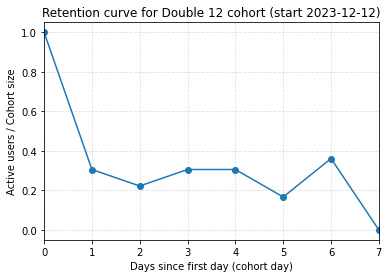

,Metric,Retention
0,D1,0.3056
1,D3,0.3056
2,D7,0.0000


In [22]:
# 简单折线图（注意：根据要求，使用 matplotlib 且不设置特定颜色）
# 仅画 0~7 天的留存
ret_0_7 = ret_series.reindex(range(0, 8), fill_value=0)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(ret_0_7.index, ret_0_7.values, marker="o")
plt.title(f"Retention curve for Double 12 cohort (start {EVENT_DATE.date()})")
plt.xlabel("Days since first day (cohort day)")
plt.ylabel("Active users / Cohort size")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlim(0, 7)
plt.show()


# 小表
ret_table = pd.DataFrame({
    "Metric": ["D1","D3","D7"],
    "Retention": [D1, D3, D7]
})
display(ret_table)

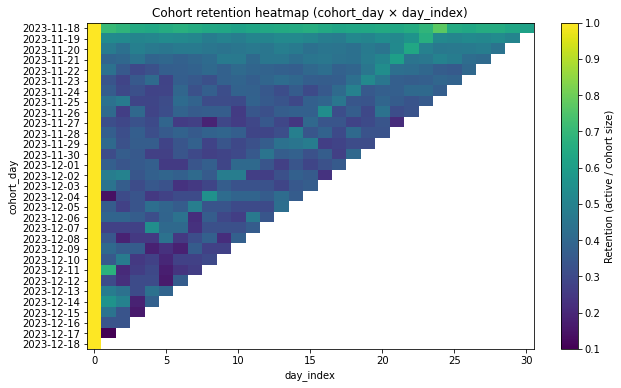

,day_index,avg_before,event_day,avg_after
0,0,1.0000,1.0000,1.0000
1,1,0.4785,0.3056,0.4951
2,2,0.3482,0.2222,0.4227
3,3,0.2928,0.3056,0.2195
4,4,0.2503,0.3056,0.4049
5,5,0.2012,0.1667,0.3913
6,6,0.2307,0.3611,0.0000
7,7,0.3011,0.0000,0.0000


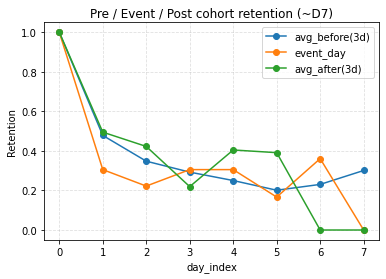

In [21]:
# 计算：所有用户的 first_day（作为 cohort），然后做日度活跃 pivot 成热力图
all_first = events.groupby("user_id", as_index=False)["timestamp"].min()
all_first["cohort_day"] = all_first["timestamp"].dt.normalize()

ev_daily = events[["user_id","timestamp"]].copy()
ev_daily["day"] = ev_daily["timestamp"].dt.normalize()
ev_daily = ev_daily.drop_duplicates()

ev_daily = ev_daily.merge(all_first[["user_id","cohort_day"]], on="user_id", how="left")
ev_daily["day_index"] = (ev_daily["day"] - ev_daily["cohort_day"]).dt.days

# 每个 cohort_day 的 cohort size
cohort_sizes = all_first.groupby("cohort_day")["user_id"].nunique()

# 活跃人数 / cohort size
active_by = ev_daily.groupby(["cohort_day","day_index"])["user_id"].nunique().to_frame("active")
heat = active_by.join(cohort_sizes.rename("cohort_size"), on="cohort_day")
heat["ret"] = (heat["active"] / heat["cohort_size"]).fillna(0)

# 仅展示 day_index 0~30
heat = heat.reset_index()
heat = heat[(heat["day_index"]>=0) & (heat["day_index"]<=30)]

# 透视为矩阵
heat_pv = heat.pivot(index="cohort_day", columns="day_index", values="ret").sort_index()

# 画热力图（imshow）
plt.figure(figsize=(10, 6))
plt.imshow(heat_pv.values, aspect="auto")
plt.colorbar(label="Retention (active / cohort size)")
plt.yticks(range(len(heat_pv.index)), [d.strftime("%Y-%m-%d") for d in heat_pv.index])
plt.xticks(range(0, heat_pv.shape[1], 5))
plt.title("Cohort retention heatmap (cohort_day × day_index)")
plt.xlabel("day_index")
plt.ylabel("cohort_day")
plt.show()

# ========== 活动日前后 Cohort 对比 ==========
# 取 [活动前3天, 活动当天, 活动后3天]
window = pd.date_range(EVENT_DATE - pd.Timedelta(days=3),
                       EVENT_DATE + pd.Timedelta(days=3), freq="D")
heat_win = heat[heat["cohort_day"].isin(window)].copy()

def avg_ret(dates):
    sub = heat_win[heat_win["cohort_day"].isin(dates)]
    if sub.empty: 
        return pd.Series(dtype=float)
    # 对齐列：day_index 0~7 足够比较
    idx = list(range(0, 8))
    ret = (sub.pivot(index="cohort_day", columns="day_index", values="ret")
              .reindex(columns=idx, fill_value=0))
    return ret.mean(axis=0)

before_dates = [d for d in window if d < EVENT_DATE]
after_dates  = [d for d in window if d > EVENT_DATE]
event_dates  = [EVENT_DATE]

avg_before = avg_ret(before_dates)
avg_after  = avg_ret(after_dates)
avg_event  = avg_ret(event_dates)

comp_df = pd.DataFrame({
    "day_index": range(0, 8),
    "avg_before": avg_before.reindex(range(0,8), fill_value=np.nan).values,
    "event_day":  avg_event.reindex(range(0,8),  fill_value=np.nan).values,
    "avg_after":  avg_after.reindex(range(0,8),  fill_value=np.nan).values,
})

display(comp_df.round(4))

# 简单对比图（3条线）
plt.figure(figsize=(6,4))
if not np.all(np.isnan(comp_df["avg_before"].values)):
    plt.plot(comp_df["day_index"], comp_df["avg_before"], marker="o", label="avg_before(3d)")
plt.plot(comp_df["day_index"], comp_df["event_day"], marker="o", label="event_day")
if not np.all(np.isnan(comp_df["avg_after"].values)):
    plt.plot(comp_df["day_index"], comp_df["avg_after"], marker="o", label="avg_after(3d)")
plt.title("Pre / Event / Post cohort retention (~D7)")
plt.xlabel("day_index")
plt.ylabel("Retention")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()


## 8、User portrait establishment

Business question: Cluster user personas based on behaviors on the purchase day

Method:
    Using Retentioneering’s path-similarity clustering, group users’ purchasing behaviors into the following patterns:
    Fast purchase (a short path: view → cart → purchase);
    Repetitive bookmarking (loops of view ↔ favorite, little cart activity);
    Add-to-cart but hesitant to buy (multiple cart events without purchase);
    Direct purchase (impulsive buyers);

Deliverables: Cluster sizes, conversion rates, and dwell steps for each cluster.


### 1.Cluster initialization

<Axes: xlabel='cluster_id', ylabel='value'>

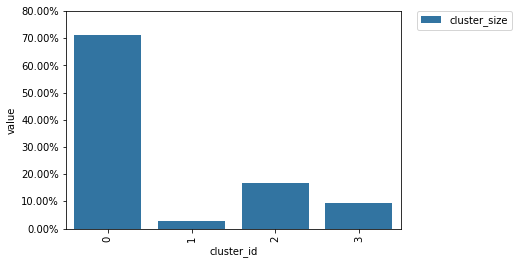

In [23]:
#初始化 Retentioneering dataset
stream = Eventstream(events)
clusters = Clusters(eventstream=stream)
features = clusters.extract_features(feature_type='tfidf', ngram_range=(1, 2))
clusters.fit(method='kmeans', n_clusters=4, X=features, random_state=42)
clusters.plot()


### 2.Basic cluster statistics

<Axes: xlabel='cluster_id', ylabel='value'>

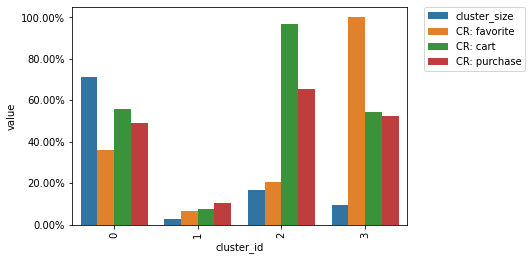

In [24]:
clusters.plot(targets=['favorite','cart', 'purchase'])

### 3.Display the contents of each cluster

### cluster0模式

In [25]:
clusters\
    .filter_cluster(cluster_id=0)\
    .add_start_end_events()\
    .transition_graph(
        targets={"positive": "purchase", "negative": "path_end"}
    )

### cluster1模式

In [26]:
clusters\
    .filter_cluster(cluster_id=1)\
    .add_start_end_events()\
    .transition_graph(
        targets={"positive": "purchase", "negative": "path_end"}
    )

### cluster2模式

In [27]:
clusters\
    .filter_cluster(cluster_id=2)\
    .add_start_end_events()\
    .transition_graph(
        targets={"positive": "purchase", "negative": "path_end"}
    )

### cluster3模式

In [28]:
clusters\
    .filter_cluster(cluster_id=3)\
    .add_start_end_events()\
    .transition_graph(
        targets={"positive": "purchase", "negative": "path_end"}
    )

## 9、Purchase behavior sequence analysis

| 字段名                    | 中文解释            | 定义 / 含义                                               | 举例说明                                                                                        |
| :--------------------- | :-------------- | :---------------------------------------------------- | :------------------------------------------------------------------------------------------ |
| **`count`**            | 出现次数            | 某条路径（例如 `"view→cart"`）在所有 session 中出现的**绝对次数**        | 如果 `"view→cart"` 出现了 1 200 次，则 count = 1200                                                 |
| **`count_share`**      | 出现次数占比          | 该路径出现次数占所有路径出现总数的比例（即频率）<br>计算公式：`count / sum(count)` | 1200 / 120 000 = 0.01 → `count_share = 1%`                                                  |
| **`session_id_share`** | session 覆盖率     | 有多少不同的 session **至少出现过** 该路径，占全部 session 的比例          | 如果 3000 个 session 中有 300 个包含 `"view→cart"`，则 `session_id_share = 0.1`（10%）                  |
| **`sequence_type`**    | 路径类型（n-gram 长度） | 表明该序列属于几步路径（n-gram 长度）                                | `"view→cart"` → `sequence_type = 2gram`<br>`"view→cart→purchase"` → `sequence_type = 3gram` |


In [26]:
#30分钟无操作视为新会话
event_stream\
    .split_sessions(timeout=(30, 'm'))\
    .sequences(
        ngram_range=(2, 3),
        weight_col='session_id',
        metrics=['count', 'count_share', 'paths_share'],
        threshold=['count', 1200],
        sorting=['count_share', False],
        heatmap_cols=['session_id_share'],
        sample_size=3
    )
event_stream.sequences()

C:\Users\24250\AppData\Roaming\Python\Python311\site-packages\retentioneering\tooling\sequences\sequences.py:88: FutureWarning: The default value of regex will change from True to False in a future version.
  cols = cols.str.replace(pattern_space, " ")


,count,count_share,session_id_share,sequence_type,session_id_sample
Sequence,,,,,
view -> view,105 809,0.34,0.82,loop,"['61506078_2', '110033398_1', '84281743_3']"
view -> view -> view,89 143,0.28,0.68,loop,"['68165769_2', '81840544_1', '109390378_3']"
session_start -> view,14 321,0.05,0.94,other,"['104613070_3', '127958351_2', '102429532_3']"
view -> session_end,14 303,0.05,0.94,other,"['60550509_2', '139946254_1', '109128473_2']"
session_start -> view -> view,11 325,0.04,0.74,other,"['11415302_2', '131424381_2', '40163921_2']"
view -> view -> session_end,11 251,0.04,0.74,other,"['3709994_1', '56376570_1', '39420666_2']"
path_start -> session_start,6 972,0.02,0.46,other,"['102178411_1', '75032548_1', '139019375_1']"
session_end -> path_end,6 972,0.02,0.46,other,"['102178411_2', '75032548_3', '139019375_3']"
path_start -> session_start -> view,6 581,0.02,0.43,other,"['111695487_1', '60314888_1', '126761012_1']"


C:\Users\24250\AppData\Roaming\Python\Python311\site-packages\retentioneering\tooling\sequences\sequences.py:88: FutureWarning: The default value of regex will change from True to False in a future version.
  cols = cols.str.replace(pattern_space, " ")


,user_id,user_id_share,count,count_share,sequence_type,user_id_sample
Sequence,,,,,,
path_end,6 972,1.00,6 972,0.05,other,['102178411']
path_start,6 972,1.00,6 972,0.05,other,['102178411']
view,6 937,0.99,126 858,0.85,other,['140990654']
cart,2 075,0.30,4 366,0.03,other,['23793674']
purchase,1 288,0.18,1 867,0.01,other,['83543222']
favorite,1 148,0.16,2 471,0.02,other,['117396268']


In [14]:
# 取每个簇的用户集合（注意：user_clusters 是属性，不要加括号）
uc = clusters.user_clusters
cluster0_users = set(uc.index[uc == 0])
cluster1_users = set(uc.index[uc == 1])

res = stream.sequences(
    ngram_range=(2, 3),
    groups=[cluster0_users, cluster1_users],
    group_names=['cluster_0', 'cluster_1'],
    weight_col='user_id',                         # 以用户为口径做 share
    metrics=['paths_share', 'count_share'],       # 合法的指标
    threshold=[('count_share', 'delta_abs'), 0],  # 用 count_share 的“绝对差”不过滤
    sorting=[('count_share', 'delta'), False],    # 按差异降序（第二组-第一组）
    # heatmap_cols=['count_share'],               # 如需热力图可指定允许的列
    # show_plot=False                             # 如需拿到 DataFrame，可加这行
)

C:\Users\24250\AppData\Roaming\Python\Python311\site-packages\retentioneering\tooling\sequences\sequences.py:88: FutureWarning: The default value of regex will change from True to False in a future version.
  cols = cols.str.replace(pattern_space, " ")
C:\Users\24250\AppData\Roaming\Python\Python311\site-packages\retentioneering\tooling\sequences\sequences.py:134: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  vec_data.loc[groups[0], "group"] = group_names[0]
C:\Users\24250\AppData\Roaming\Python\Python311\site-packages\retentioneering\tooling\sequences\sequences.py:135: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  vec_data.loc[groups[1], "group"] = group_names[1]
